## Building and Training the Model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load and preprocess dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255, test_images / 255

In [4]:
print("Training:",train_images.shape)
print("Testing:",test_images.shape)

Training: (50000, 32, 32, 3)
Testing: (10000, 32, 32, 3)


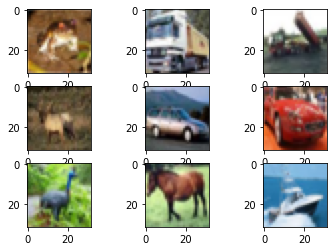

In [5]:
for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(train_images[i])
plt.show()

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
#Setup data augmentation
traingen = ImageDataGenerator(
    rotation_range=0,
    horizontal_flip=True,
    vertical_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
traingen.fit(train_images)

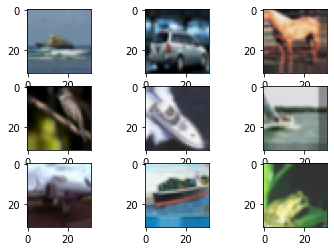

In [8]:
#Show example augmented images
for X_batch, y_batch in traingen.flow(train_images, train_labels, batch_size=9):
    for i in range(0,9):
        plt.subplot(330+1+i)
        plt.imshow(X_batch[i])
    plt.show()
    break

In [9]:
#make images
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)
test_images = test_images.reshape(test_images.shape[0], 32, 32, 3)
input_shape = (32, 32, 1)
print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

train_images shape: (50000, 32, 32, 3)
test_images shape: (10000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
convModel = models.Sequential([
    #3x3_96    
    layers.Conv2D(96, (3,3), activation='relu', input_shape=(32,32,3),
                  padding='same', name='3x3_1'),
    layers.Conv2D(96, (3,3), activation='relu', 
                  padding='same', name='3x3_2'),
    layers.Conv2D(96, (3,3), activation='relu', 
                  padding='valid', strides=[2,2], name='poolconv_1'),
    layers.Dropout(0.5),
    
    #3x3_192
    layers.Conv2D(192, (3,3), activation='relu', input_shape=(32, 32, 3),
                  padding='same', name='3x3_3'),
    layers.Conv2D(192, (3,3), activation='relu', 
                  padding='same', name='3x3_4'),
    layers.Conv2D(192, (3,3), activation='relu', 
                  padding='valid', strides=[2,2], name='poolconv_2'),
    layers.Dropout(0.5),
    
    #3x3&1x1
    layers.Conv2D(192, (3,3), activation='relu', 
                  padding='same', name='3x3_6'),
    layers.Conv2D(192, (1,1), activation='relu', 
                  padding='valid', name='1x1_1'),
    layers.Conv2D(10, (1,1), activation='relu', 
                  padding='valid', name='1x1_2'),
    layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D'),
    layers.Activation('softmax')
], name = "convModel")

convModel.summary()

Model: "convModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3x3_1 (Conv2D)               (None, 32, 32, 96)        2688      
_________________________________________________________________
3x3_2 (Conv2D)               (None, 32, 32, 96)        83040     
_________________________________________________________________
poolconv_1 (Conv2D)          (None, 15, 15, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 96)        0         
_________________________________________________________________
3x3_3 (Conv2D)               (None, 15, 15, 192)       166080    
_________________________________________________________________
3x3_4 (Conv2D)               (None, 15, 15, 192)       331968    
_________________________________________________________________
poolconv_2 (Conv2D)          (None, 7, 7, 192)         33

In [11]:
#Optimizer
#opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=5e-8)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [12]:
convModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
BATCHSIZE = 100
EPOCHS = 100

#traingen.fit(train_images)
#traindata = traingen.flow(train_images, train_labels)

# With Augmentation
history = convModel.fit(traingen.flow(train_images, train_labels, batch_size=BATCHSIZE), 
                        epochs=EPOCHS, verbose=1, 
                        validation_data=(test_images,test_labels))

# Without Augmentation
#history = convModel.fit(train_images, train_labels, batch_size=BATCHSIZE, 
#                        epochs=EPOCHS, verbose=1, 
#                       validation_data=(test_images,test_labels))


Epoch 1/100
500/500 [==============================] - 18s 37ms/step - loss: 2.2391 - accuracy: 0.0000e+00 - val_loss: 2.1989 - val_accuracy: 0.0000e+00
Epoch 2/100
500/500 [==============================] - 18s 36ms/step - loss: 2.1874 - accuracy: 0.0000e+00 - val_loss: 2.1394 - val_accuracy: 0.0000e+00
Epoch 3/100
432/500 [========================>.....] - ETA: 2s - loss: 2.1642 - accuracy: 0.0000e+00

KeyboardInterrupt: 

313/313 - 1s - loss: 2.0472 - accuracy: 0.4137


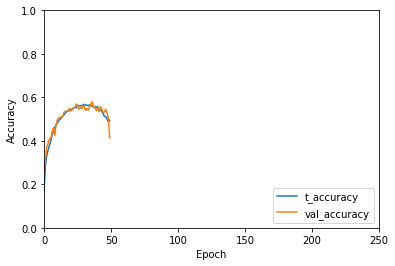

In [15]:
plt.plot(history.history['accuracy'], label='t_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.xlim([0, 250])
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = convModel.evaluate(test_images,  test_labels, verbose=2)

In [16]:
convModel.save("convCifar10")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: convCifar10/assets


## Loading and Evaluating the Model

In [54]:
cifar10model = models.load_model("convCifar10")

In [55]:
t1 = time.time()
loss, acc = cifar10model.evaluate(test_images, test_labels, verbose=2)
t2 = time.time()

print("elapsed:", (t2-t1)*1000, "ms")
print("average:", (t2-t1)*1000/(test_images.shape[0]), "ms")

313/313 - 1s - loss: 2.0139 - accuracy: 0.0696
elapsed: 1341.4077758789062 ms
average: 0.13414077758789061 ms


In [56]:
# Continued Training

history = cifar10model.fit(train_images, train_labels, epochs=300,
                         validation_data=(test_images, test_labels))

Epoch 1/300
 607/1563 [==========>...................] - ETA: 6s - loss: 2.0566 - accuracy: 0.1068

KeyboardInterrupt: 

10000/10000 - 12s - loss: 1.2541 - accuracy: 0.6078


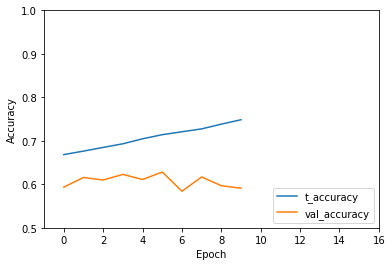

In [25]:
plt.plot(history.history['accuracy'], label='t_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.xlim([-1, 16])
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = newModel.evaluate(test_images,  test_labels, verbose=2)